In [1]:
%cd C:\Users\spenc\Desktop\OpenBCSim\pytorch_extension\openbcsim\jupyter

C:\Users\spenc\Desktop\OpenBCSim\pytorch_extension\openbcsim\jupyter


In [1]:
import sys
path = '../install'
if path not in sys.path: sys.path.append (path) # Path to openbcsim extension
import Simulator as bc
import openbcsim
import Transducer
import importlib as imp
imp.reload (openbcsim)
imp.reload (Transducer)
imp.reload (bc)

<module 'Simulator' from '../install\\Simulator.py'>

In [2]:
class Params:    
    def __init__ (self):
        f0 = 3.5e6                 #  Transducer center frequency [Hz]
        fs = 100e6                 #  Sampling frequency [Hz]
        c = 1540                   #  Speed of sound [m/s]
        lambd = c / f0             #  Wavelength [m]
        width = lambd              #  Width of element
        height = 5 / 1000          #  Height of element [m]
        kerf = 0.05 / 1000         #  Kerf (gap between elements) [m]
        pitch = kerf + width       #  Pitch (center-to-center distance between elements) [m]
        N_elements = 192           #  Number of physical elements
        no_sub_x = 1               #  Number of sub-divisions in x-direction of elements
        no_sub_y = 10              #  Number of sub-divisions in y-direction of elements
        
        N_active = 64              #  Number of active elements 
        z_focus = 60 / 1000        #  Transmit focus
        
#         no_lines = 50                 #  Number of lines in image
        no_lines = 2                  #  Number of lines in image
        image_width = 40 / 1000       #  Size of image sector
        d_x = image_width / no_lines  #  Increment for image
        
        scope = locals ()
        scope.pop ('self')
        for k,v in scope.items ():
            setattr (self, k, v)
            
    def __repr__ (self):
        from pprint import pformat
        return pformat (vars (self))

PARAMS = Params ()
print (PARAMS)

{'N_active': 64,
 'N_elements': 192,
 'c': 1540,
 'd_x': 0.02,
 'f0': 3500000.0,
 'fs': 100000000.0,
 'height': 0.005,
 'image_width': 0.04,
 'kerf': 5e-05,
 'lambd': 0.00044,
 'no_lines': 2,
 'no_sub_x': 1,
 'no_sub_y': 10,
 'pitch': 0.00049,
 'width': 0.00044,
 'z_focus': 0.06}


In [3]:
from pprint import pprint

tx = bc.LinearTransducer (
    num_elements=PARAMS.N_elements,
    width=PARAMS.lambd,
    height=PARAMS.height,
    kerf=PARAMS.kerf,
    num_sub_x=PARAMS.no_sub_x,
    num_sub_y=PARAMS.no_sub_y,
    center_frequency=PARAMS.f0,
)

rx = tx.copy ()

In [4]:
import numpy as np
count = PARAMS.no_lines
step = PARAMS.d_x
focal_x = tx.centered_range (count, step)
focal_z = PARAMS.z_focus
focal_points = [(x, 0, focal_z) for x in focal_x]

tx.set_delays (focal_points=focal_points)
tx.plot_delays ()

<Figure size 800x550 with 1 Axes>

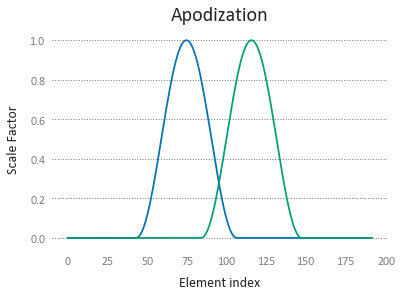

In [5]:
hanning = np.hanning (PARAMS.N_active)
step = tx.x[tx.subdivision_factor] - tx.x[0]
bins = np.arange (hanning.size) - hanning.size//2
def map_func (X,Y,Z,focus):
    import torch
    X = X.cpu ().numpy ()
    index = (X - focus[0]) / step
    return np.interp (index, bins, hanning)

tx.set_apodization (map_func=map_func)
tx.plot_apodization ()

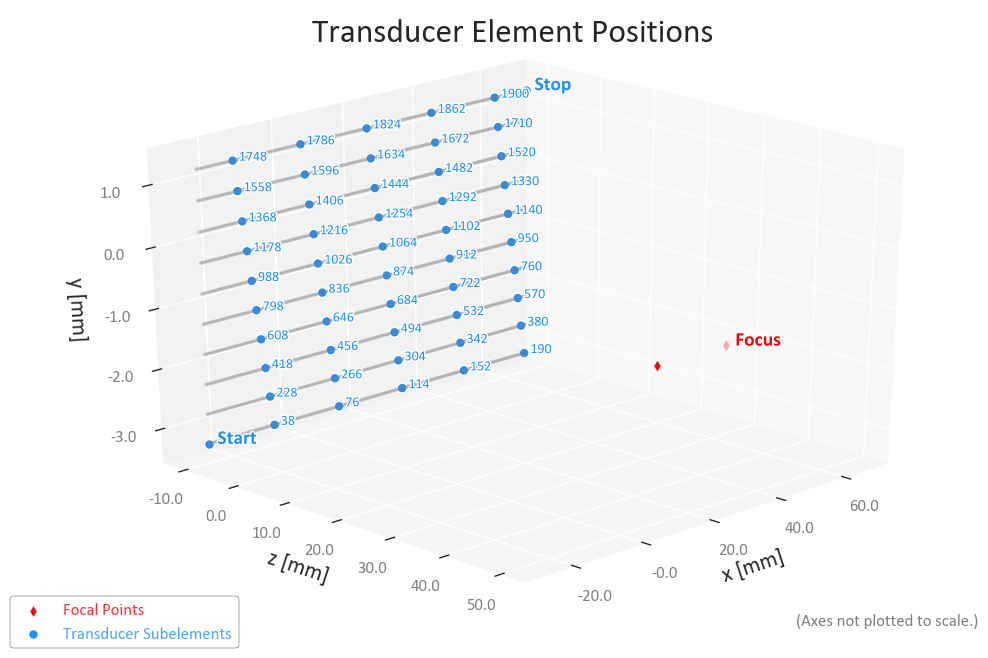

In [6]:
tx.plot ()

In [7]:
sim = bc.Simulator (
    sampling_frequency=PARAMS.fs,
    decimation=10,
    scan_depth=.09,
    speed_of_sound=PARAMS.c,
    attenuation=0.7,
    tx=tx,
    rx=rx,
)

pprint (vars (sim))

{'attenuation': 0.7,
 'decimation': 10,
 'device': 'cuda',
 'dtype': torch.float32,
 'new_ones': <bound method Transducer.new_ones of LinearTransducer (num_elements=192, width=0.00044, height=0.005, kerf=5e-05, num_sub_x=1, num_sub_y=10, center_frequency=3500000.0, dtype=torch.float32, device='cuda')>,
 'new_tensor': <bound method Transducer.new_tensor of LinearTransducer (num_elements=192, width=0.00044, height=0.005, kerf=5e-05, num_sub_x=1, num_sub_y=10, center_frequency=3500000.0, dtype=torch.float32, device='cuda')>,
 'new_zeros': <bound method Transducer.new_zeros of LinearTransducer (num_elements=192, width=0.00044, height=0.005, kerf=5e-05, num_sub_x=1, num_sub_y=10, center_frequency=3500000.0, dtype=torch.float32, device='cuda')>,
 'num_time_samples': 11689,
 'rx': LinearTransducer (num_elements=192, width=0.00044, height=0.005, kerf=5e-05, num_sub_x=1, num_sub_y=10, center_frequency=3500000.0, dtype=torch.float32, device='cuda'),
 'sampling_frequency': 100000000.0,
 'scan_dep

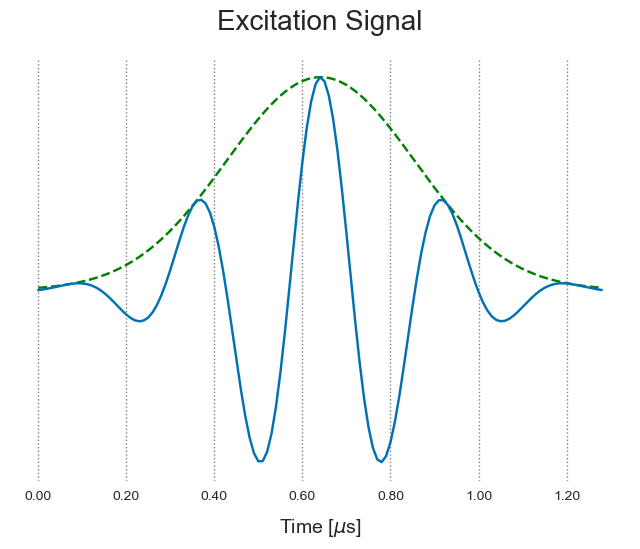

In [8]:
sim.set_gaussian_excitation (plot=True)

In [9]:
sim.load_field_ii_scatterers ('../data/Field II/cyst_phantom/pht_data.mat')

Loading Field II scatterer data from "..\data\Field II\cyst_phantom\pht_data.mat"
Scatterer data loaded. Total # scatterers: 100,000


In [10]:
sim.get_stats ()

Output buffer shape        [2, 192, 11689, 2]   = [focal pts.] x [rx elems.] x [time pts.] x [real|imag]
Output buffer memory       35.9 MB
Time samples               11,689              
Transmitter subelements    1,920               
Receiver subelements       1,920               
Scatterer samples          100,000             
CUDA grid blocks           [320, 1, 1]         
CUDA thread count          327,680              = [1024 threads/block] x [Total grid blocks]



In [12]:
result = sim.launch (convolve=False) # (32, 10, 10)
print (result.shape)
print (result)

453.48 seconds
Theoretical memory bandwidth: 192.2 GB/s
Actual memory bandwidth: 0.000 GB/s
Threads per second: 722.6
torch.Size([2, 192, 11689, 2])
tensor([[[[   0.0000,    0.0000],
          [   0.0000,    0.0000],
          [   0.0000,    0.0000],
          ...,
          [  -0.0000,   -8.9721],
          [   0.0841,   -6.0363],
          [   0.0279,   -5.2247]],

         [[   0.0000,    0.0000],
          [   0.0000,    0.0000],
          [   0.0000,    0.0000],
          ...,
          [  -0.0124,    2.1957],
          [   0.0301,    3.9349],
          [  -0.0377,    2.4841]],

         [[   0.0000,    0.0000],
          [   0.0000,    0.0000],
          [   0.0000,    0.0000],
          ...,
          [   0.0874,  -13.1694],
          [  -0.0940,  -10.3343],
          [  -0.0902,   -6.9857]],

         ...,

         [[   0.0000,    0.0000],
          [   0.0000,    0.0000],
          [   0.0000,    0.0000],
          ...,
          [   0.0303,    1.7618],
          [   0.0133, 

In [ ]:
times = {
    400: 172.6,
    450: 196.9,
    550: 244.4,
    'bleh': None,
}
import json
from pathlib import Path
with Path ('times.json').open ('wt') as f:
    json.dump (times, f)